# Job Title Recommendation from Skill Sets

This notebook performs exploratory data analysis, cleans the job skill data, engineers features, trains an XGBoost classifier, and logs the experiment to MLflow. The resulting model can suggest likely job titles for a given set of skills.

In [1]:
import ast
import json
import os
from pathlib import Path

import mlflow
from mlflow.models import infer_signature
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

sns.set_theme(style='whitegrid')
pd.set_option('display.max_colwidth', 120)

In [11]:
def find_project_root(start: Path, marker: str = 'data') -> Path:
    current = start.resolve()
    for _ in range(5):
        if (current / marker).exists():
            return current
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('Unable to locate project root containing a data directory.')


PROJECT_ROOT = find_project_root(Path.cwd())
DATA_PATH = (PROJECT_ROOT / 'data' / 'all_job_post.csv').resolve()
ARTIFACTS_DIR = (PROJECT_ROOT / 'artifacts' / 'job_title_from_skills').resolve()
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

EXPERIMENT_NAME = 'job_title_from_skills_xgb'
RANDOM_STATE = 42
TEST_SIZE = 0.2
MIN_TITLE_FREQ = 5

print(f'Using data at: {DATA_PATH}')
mlflow.set_experiment(EXPERIMENT_NAME)
print(f'\nMLflow experiment: {EXPERIMENT_NAME}')

Using data at: C:\Users\ebina\Documents\GitHub\SkillGapPipeline\data\all_job_post.csv

MLflow experiment: job_title_from_skills_xgb


In [4]:
df_raw = pd.read_csv(DATA_PATH)
print(f'Raw shape: {df_raw.shape}')
df_raw.head()

Raw shape: (1167, 5)


,job_id,category,job_title,job_description,job_skill_set
0,3902668440,HR,Sr Human Resource Generalist,"SUMMARY\nTHE SR. HR GENERALIST PROVIDES HR EXPERTISE ACROSS VARIOUS FUNCTIONS INCLUDING EMPLOYEE RELATIONS, TALENT A...","['employee relations', 'talent acquisition', 'performance management', 'compensation and benefits', 'employment laws..."
1,3905823748,HR,Human Resources Manager,BE PART OF A STELLAR TEAM AT YSB AS THE MANAGER OF HUMAN RESOURCES. JOIN US AS YSB ENTERS A NEW AND VIBRANT ERA WITH...,"['Talent Acquisition', 'Employee Performance Management', 'Legal Compliance', 'Payroll Processing', 'Microsoft Offic..."
2,3905854799,HR,Director of Human Resources,OUR CLIENT IS A THRIVING ORGANIZATION OFFERING A UNIQUE OPPORTUNITY FOR A DIRECTOR OF HUMAN RESOURCES TO JOIN ITS DY...,"['Human Resources Management', 'Recruitment', 'Employee Relations', 'Performance Management', 'Compliance with Labor..."
3,3905834061,HR,Chief Human Resources Officer,JOB TITLE: CHIEF HUMAN RESOURCES OFFICER (CHRO)INDUSTRY: ENTERTAINMENT & MEDIA \nJOB DESCRIPTION:EAST 57TH STREET PA...,"['talent management', 'organizational development', 'HR compliance', 'HR technology systems', 'data-driven HR analyt..."
4,3906250451,HR,Human Resources Generalist (Hybrid Role),DESCRIPTION\n\n WHO WE ARE \n\nAVI-SPL IS A DIGITAL ENABLEMENT SOLUTIONS PROVIDER WHO TRANSFORMS HOW PEOPLE AND TECH...,"['Microsoft Office', 'Data analysis', 'Employee onboarding', 'Strategic thinking', 'Problem solving', 'Time manageme..."


In [5]:
df_raw.info()
missing_ratio = df_raw.isna().mean().sort_values(ascending=False)
print('Missing value ratio per column:')
missing_ratio.to_frame('missing_ratio')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           1167 non-null   int64 
 1   category         1167 non-null   object
 2   job_title        1167 non-null   object
 3   job_description  1167 non-null   object
 4   job_skill_set    1167 non-null   object
dtypes: int64(1), object(4)
memory usage: 45.7+ KB
Missing value ratio per column:


,missing_ratio
job_id,0.0
category,0.0
job_title,0.0
job_description,0.0
job_skill_set,0.0


In [6]:
def normalize_token(token: str) -> str:
    token = token.lower().strip()
    token = token.replace('/', ' ').replace('&', ' and ').replace('-', ' ')
    token = '_'.join(token.split())
    return token


def parse_skills(value):
    if pd.isna(value):
        return []
    if isinstance(value, (list, tuple, set)):
        iterable = value
    else:
        try:
            iterable = ast.literal_eval(value)
        except (ValueError, SyntaxError):
            iterable = [item.strip() for item in str(value).split(',')]
    skills = []
    for item in iterable:
        token = str(item).strip()
        if not token:
            continue
        normalized = normalize_token(token)
        if normalized:
            skills.append(normalized)
    return skills


df = df_raw.copy()
df['job_title'] = df['job_title'].astype(str).str.strip()
df['skills_list'] = df['job_skill_set'].apply(parse_skills)
df['skills_text'] = df['skills_list'].apply(lambda skills: ' '.join(skills))
df['num_skills'] = df['skills_list'].apply(len)
df = df[df['skills_text'].str.len() > 0].copy()

print(f'Rows after cleaning: {df.shape[0]}')
df[['job_title', 'skills_list', 'num_skills']].head()

Rows after cleaning: 1167


,job_title,skills_list,num_skills
0,Sr Human Resource Generalist,"[employee_relations, talent_acquisition, performance_management, compensation_and_benefits, employment_laws_and_regu...",27
1,Human Resources Manager,"[talent_acquisition, employee_performance_management, legal_compliance, payroll_processing, microsoft_office, policy...",16
2,Director of Human Resources,"[human_resources_management, recruitment, employee_relations, performance_management, compliance_with_labor_laws, da...",20
3,Chief Human Resources Officer,"[talent_management, organizational_development, hr_compliance, hr_technology_systems, data_driven_hr_analytics, comp...",18
4,Human Resources Generalist (Hybrid Role),"[microsoft_office, data_analysis, employee_onboarding, strategic_thinking, problem_solving, time_management, attenti...",20


In [7]:
print(f"Unique categories: {df['category'].nunique()}")
print(f"Unique job titles: {df['job_title'].nunique()}")
print(f"Average # of skills per posting: {df['num_skills'].mean():.2f}")

Unique categories: 5
Unique job titles: 720
Average # of skills per posting: 17.85


C:\Users\ebina\AppData\Local\Temp\ipykernel_25584\3448266918.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


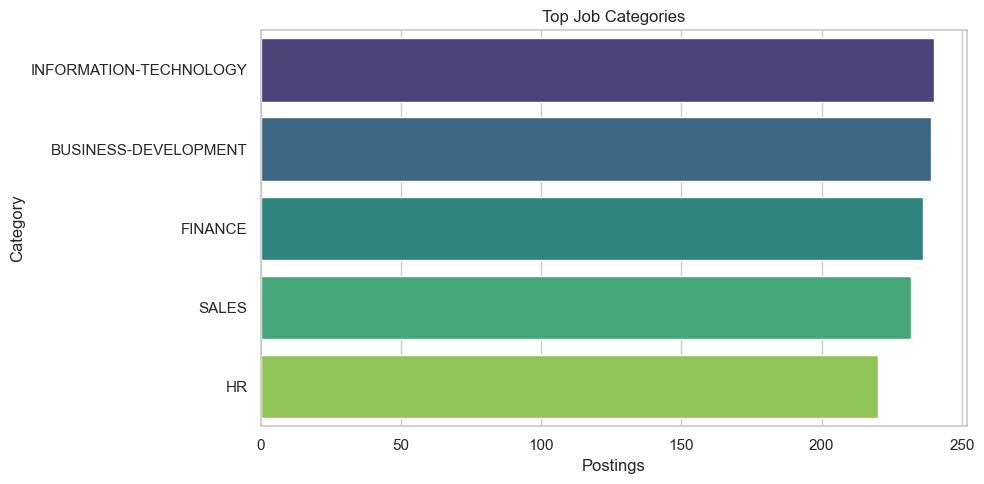

In [8]:
top_categories = df['category'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top Job Categories')
plt.xlabel('Postings')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

C:\Users\ebina\AppData\Local\Temp\ipykernel_30024\2548612910.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_titles.values, y=top_titles.index, palette='magma')


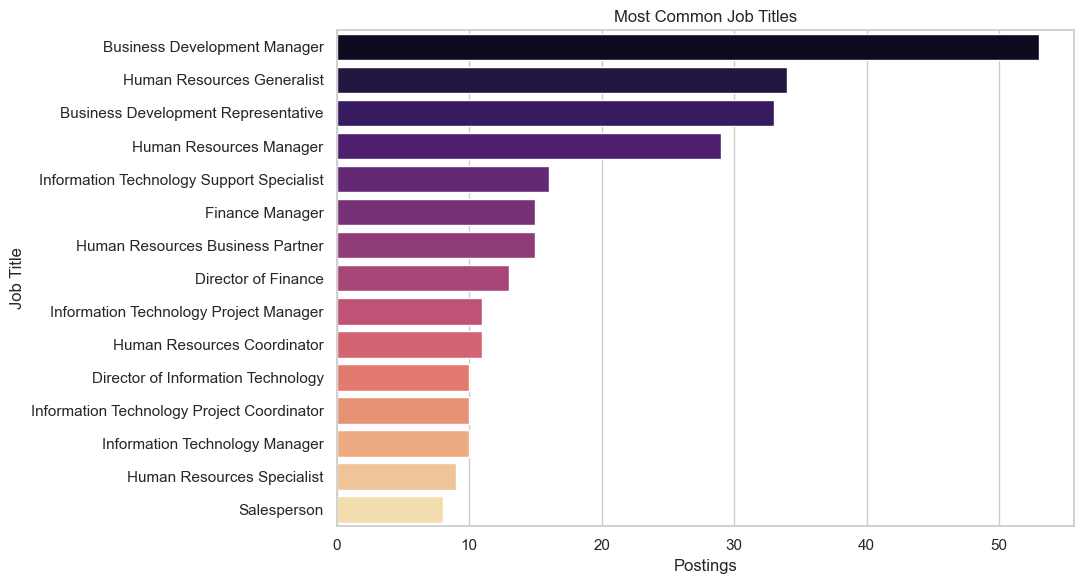

In [8]:
top_titles = df['job_title'].value_counts().head(15)
plt.figure(figsize=(11, 6))
sns.barplot(x=top_titles.values, y=top_titles.index, palette='magma')
plt.title('Most Common Job Titles')
plt.xlabel('Postings')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

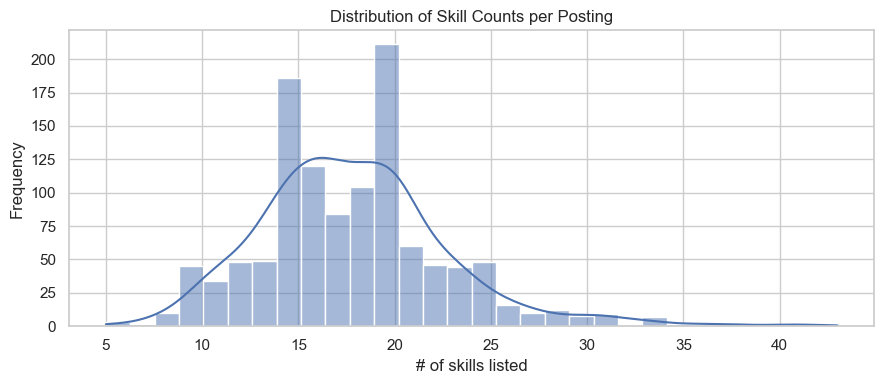

In [9]:
plt.figure(figsize=(9, 4))
sns.histplot(df['num_skills'], bins=30, kde=True)
plt.title('Distribution of Skill Counts per Posting')
plt.xlabel('# of skills listed')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [10]:
skill_frequency = df['skills_list'].explode().value_counts().head(20)
skill_frequency.to_frame('frequency')

,frequency
skills_list,
communication,1092
problem_solving,933
adaptability,588
teamwork,569
collaboration,341
leadership,325
time_management,316
interpersonal_skills,288
customer_service,272


In [12]:
title_counts = df['job_title'].value_counts()
eligible_titles = title_counts[title_counts >= MIN_TITLE_FREQ].index
filtered_df = df[df['job_title'].isin(eligible_titles)].copy()

print(f"Rows after filtering rare titles (<{MIN_TITLE_FREQ} samples): {filtered_df.shape[0]}")
print(f"Remaining job titles: {filtered_df['job_title'].nunique()}")

Rows after filtering rare titles (<5 samples): 383
Remaining job titles: 33


In [13]:
X = filtered_df['skills_text']
y = filtered_df['job_title']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f'Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}')
print(f"Classes: {len(label_encoder.classes_)}")

Train size: 306 | Test size: 77
Classes: 33


In [14]:
tfidf_params = dict(ngram_range=(1, 2), min_df=2, max_features=5000)
xgb_params = dict(
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    learning_rate=0.1,
    max_depth=8,
    n_estimators=400,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', XGBClassifier(**xgb_params)),
])

run_name = 'xgb_job_title_recommender'
sample_input = ['python machine_learning data_analysis']

with mlflow.start_run(run_name=run_name) as run:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')

    print(f'Test accuracy: {acc:.4f}')
    print(f'Macro F1: {macro_f1:.4f}')
    print(f'Micro F1: {micro_f1:.4f}')

    mlflow.log_params({
        'tfidf_max_features': tfidf_params['max_features'],
        'tfidf_min_df': tfidf_params['min_df'],
        'tfidf_ngram_high': tfidf_params['ngram_range'][1],
        'xgb_learning_rate': xgb_params['learning_rate'],
        'xgb_max_depth': xgb_params['max_depth'],
        'xgb_estimators': xgb_params['n_estimators'],
        'xgb_subsample': xgb_params['subsample'],
        'xgb_colsample_bytree': xgb_params['colsample_bytree'],
        'min_title_freq': MIN_TITLE_FREQ,
        'train_size': len(X_train),
        'test_size': len(X_test),
    })

    mlflow.log_metrics({
        'test_accuracy': acc,
        'test_macro_f1': macro_f1,
        'test_micro_f1': micro_f1,
    })

    report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)
    report_path = ARTIFACTS_DIR / 'classification_report.json'
    with open(report_path, 'w', encoding='utf-8') as f:
        json.dump(report_dict, f, indent=2)
    mlflow.log_artifact(report_path, artifact_path='reports')

    report_txt = classification_report(y_test_labels, y_pred_labels)
    report_txt_path = ARTIFACTS_DIR / 'classification_report.txt'
    with open(report_txt_path, 'w', encoding='utf-8') as f:
        f.write(report_txt)
    mlflow.log_artifact(report_txt_path, artifact_path='reports')

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_mat, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix (encoded labels)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    fig.tight_layout()
    conf_mat_path = ARTIFACTS_DIR / 'confusion_matrix.png'
    fig.savefig(conf_mat_path, dpi=200)
    plt.close(fig)
    mlflow.log_artifact(conf_mat_path, artifact_path='plots')

    label_mapping = {int(idx): label for idx, label in enumerate(label_encoder.classes_)}
    mapping_path = ARTIFACTS_DIR / 'label_mapping.json'
    with open(mapping_path, 'w', encoding='utf-8') as f:
        json.dump(label_mapping, f, indent=2)
    mlflow.log_artifact(mapping_path, artifact_path='preprocessing')

    signature = infer_signature(np.array(sample_input), pipeline.predict(sample_input))
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path='model',
        registered_model_name='job_title_from_skills_xgb',
        signature=signature,
        input_example=sample_input,
    )

run

Test accuracy: 0.2857
Macro F1: 0.2233
Micro F1: 0.2857


C:\Users\ebina\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ebina\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ebina\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

c:\Users\ebina\.conda\envs\pytorch_gpu\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
Registered model 'job_title_from_skills_xgb' already exists. Creating a new version of this model...
Created version '2' of model 'job_title_from_skills_xgb'.


<ActiveRun: >

In [15]:
report_df = pd.DataFrame(report_dict).transpose()
report_df.head(15)

,precision,recall,f1-score,support
Business Development Associate,0.000000,0.000000,0.000000,1.0
Business Development Executive,1.000000,1.000000,1.000000,1.0
Business Development Manager,0.400000,0.181818,0.250000,11.0
Business Development Representative,0.250000,0.428571,0.315789,7.0
Business Development Specialist,0.000000,0.000000,0.000000,1.0
Director of Business Development,0.000000,0.000000,0.000000,1.0
Director of Finance,0.250000,0.333333,0.285714,3.0
Director of Human Resources,0.000000,0.000000,0.000000,1.0
Director of Information Technology,0.000000,0.000000,0.000000,2.0
Finance Manager,1.000000,0.333333,0.500000,3.0


In [16]:
def prepare_text_from_skills(skills):
    if isinstance(skills, str):
        iterable = [token.strip() for token in skills.split(',') if token.strip()]
    else:
        iterable = skills
    return ' '.join(normalize_token(skill) for skill in iterable)


def recommend_job_titles(skills, top_k=5):
    skills_text = prepare_text_from_skills(skills)
    probs = pipeline.predict_proba([skills_text])[0]
    top_indices = np.argsort(probs)[::-1][:top_k]
    recommendations = []
    for rank, idx in enumerate(top_indices, start=1):
        recommendations.append({
            'rank': rank,
            'job_title': label_encoder.inverse_transform([idx])[0],
            'probability': float(probs[idx]),
        })
    return recommendations

example_skills = ['python', 'machine learning', 'natural language processing', 'data visualization']
pd.DataFrame(recommend_job_titles(example_skills))

,rank,job_title,probability
0,1,Business Development Specialist,0.499895
1,2,Information Technology System Administrator,0.161687
2,3,Business Development Representative,0.090307
3,4,Director of Human Resources,0.025189
4,5,Information Technology Support Specialist,0.022254
